In [1]:
using Distributions
using Printf
using Random
Random.seed!(4649373)
using StaticArrays
using StatsBase
using StatsPlots
default(fmt = :png, titlefontsize=10, size = (400, 250))

In [74]:
function chisqstat(x, n, p)
    sum((x[i] - n*p[i])^2/(n*p[i]) for i in eachindex(p))
end

pval(r, chi2) = ccdf(Chisq(r - 1), chi2)
pval(x, n, p) = pval(length(p), chisqstat(x, n, p))

function mcsim(n, p₀, p = p₀; L = 10^6)
    dist_true = Multinomial(n, p₀)
    C = Vector{Float64}(undef, L)
    P = similar(C)
    Z = Vector{Int}(undef, L)
    r = length(p₀)
    tmp = [Vector{Int}(undef, r) for _ in 1:Threads.nthreads()]
    Threads.@threads for i in 1:L
        X = rand!(dist_true, tmp[Threads.threadid()])
        C[i] = chisqstat(X, n, p)
        P[i] = pval(r, C[i])
        Z[i] = count(==(0), X)
    end
    ecdfC, ecdfP = ecdf(C), ecdf(P)
    countZ = count.(.==(0:r-1), Ref(Z))
    ecdfC, ecdfP, countZ, C, P, Z
end

function plot_mcsim(n, p₀, p = p₀; L = 10^6)
    r = length(p₀)
    ecdfC, ecdfP, countZ, C, P, Z = mcsim(n, p₀, p; L)
    prob_numzero = countZ / L
    
    P1 = plot(; legend = :bottomright)
    plot!(x -> ecdfC(x), 0, r+4√(2r); label="ecdf(χ²-stats)")
    plot!(x -> cdf(Chisq(r-1), x); label="cdf(Chisq($(r-1)))", ls=:dash)

    P2 = plot(; legend = :topleft)
    plot!(x -> ecdfP(x), 0, 0.1; label="ecdf(p-values)")
    plot!(x -> cdf(Uniform(), x); label="cdf(Uniform())", ls=:dash)
    
    @show n
    @show p₀
    p != p₀ && @show p
    @show n*p₀
    p != p₀ && @show n*p
    @show prob_numzero
    plot(P1, P2; size=(600, 250))
end

eprob(v) = v / sum(v)

function evenprob(t, v = ones(6))
    s = sum(v)
    a, b, c = (v[1]+v[2], v[3]+v[4], v[5]+v[6]) ./ s
    SVector((1-t)*a, t*a, (1-t)*b, t*b, (1-t)*c, t*c)
end

evenprob (generic function with 2 methods)

n = 10
p₀ = [0.08333333333333333, 0.25, 0.08333333333333333, 0.25, 0.08333333333333333, 0.25]
n * p₀ = [0.8333333333333333, 2.5, 0.8333333333333333, 2.5, 0.8333333333333333, 2.5]
prob_numzero = [0.122285, 0.422775, 0.365619, 0.086275, 0.003043, 3.0e-6]


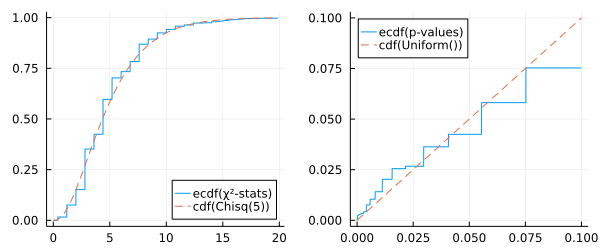

In [75]:
plot_mcsim(10, evenprob(0.75))

In [76]:
plot_mcsim(20, evenprob(0.75))

n = 20
p₀ = [0.08333333333333333, 0.25, 0.08333333333333333, 0.25, 0.08333333333333333, 0.25]
n * p₀ = [1.6666666666666665, 5.0, 1.6666666666666665, 5.0, 1.6666666666666665, 5.0]
prob_numzero = [0.542076, 0.383701, 0.070865, 0.003354, 4.0e-6, 0.0]


n = 30
p₀ = [0.08333333333333333, 0.25, 0.08333333333333333, 0.25, 0.08333333333333333, 0.25]
n * p₀ = [2.5, 7.5, 2.5, 7.5, 2.5, 7.5]
prob_numzero = [0.791476, 0.196197, 0.012178, 0.000149, 0.0, 0.0]


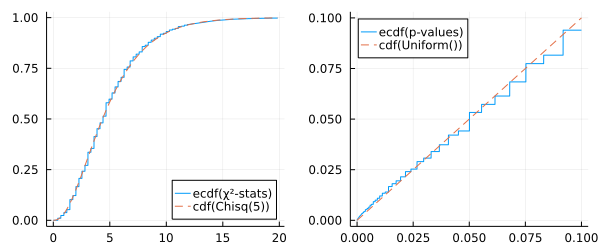

In [77]:
plot_mcsim(30, evenprob(0.75))

n = 100
p₀ = [0.08333333333333333, 0.25, 0.08333333333333333, 0.25, 0.08333333333333333, 0.25]
n * p₀ = [8.333333333333332, 25.0, 8.333333333333332, 25.0, 8.333333333333332, 25.0]
prob_numzero = [0.999501, 0.000498, 1.0e-6, 0.0, 0.0, 0.0]


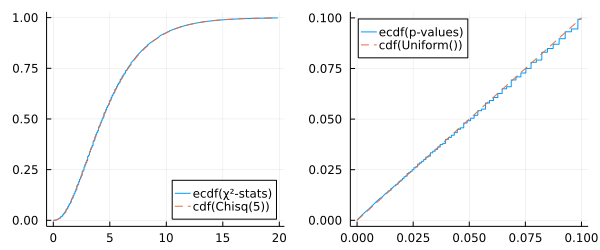

In [78]:
plot_mcsim(100, evenprob(0.75))

n = 24
p₀ = [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
n * p₀ = [4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
prob_numzero = [0.925673, 0.073409, 0.000916, 2.0e-6, 0.0, 0.0]


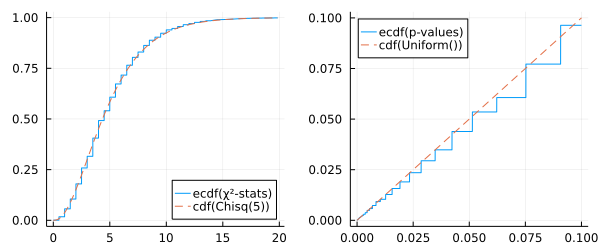

In [79]:
plot_mcsim(24, evenprob(0.5))

In [80]:
plot_mcsim(10, eprob([1, 2, 3, 5, 8, 13]))

n = 10
p₀ = [0.03125, 0.0625, 0.09375, 0.15625, 0.25, 0.40625]
n * p₀ = [0.3125, 0.625, 0.9375, 1.5625, 2.5, 4.0625]
prob_numzero = [0.042852, 0.283545, 0.453251, 0.201034, 0.019186, 0.000132]


In [81]:
plot_mcsim(20, eprob([1, 2, 3, 5, 8, 13]))

n = 20
p₀ = [0.03125, 0.0625, 0.09375, 0.15625, 0.25, 0.40625]
n * p₀ = [0.625, 1.25, 1.875, 3.125, 5.0, 8.125]
prob_numzero = [0.268698, 0.502859, 0.20803, 0.020181, 0.000232, 0.0]


In [82]:
plot_mcsim(30, eprob([1, 2, 3, 5, 8, 13]))

n = 30
p₀ = [0.03125, 0.0625, 0.09375, 0.15625, 0.25, 0.40625]
n * p₀ = [0.9375, 1.875, 2.8125, 4.6875, 7.5, 12.1875]
prob_numzero = [0.487902, 0.436734, 0.073129, 0.00223, 5.0e-6, 0.0]


n = 100
p₀ = [0.03125, 0.0625, 0.09375, 0.15625, 0.25, 0.40625]
n * p₀ = [3.125, 6.25, 9.375, 15.625, 25.0, 40.625]
prob_numzero = [0.956813, 0.043127, 6.0e-5, 0.0, 0.0, 0.0]


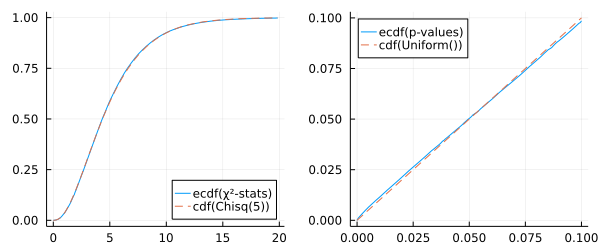

In [83]:
plot_mcsim(100, eprob([1, 2, 3, 5, 8, 13]))

n = 100
p₀ = [0.2, 0.8]
n * p₀ = [20.0, 80.0]
prob_numzero = [1.0, 0.0]


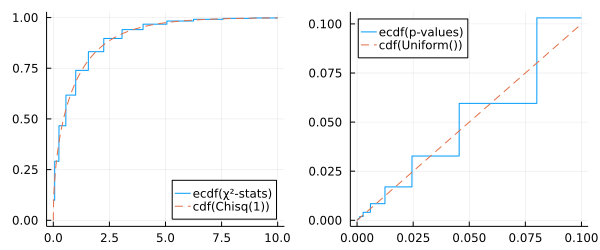

In [93]:
plot_mcsim(100, eprob([2, 8]))

In [12]:
function plot_pvaluefunction!(x, n, p; kwargs...)
    plot!(f, 0, 1; label="", kwargs...)
end

function plot_pvaluefunctions(n, p₀; L=100)
    @show n
    @show p₀
    @show n*p₀
    dist_true = Multinomial(n, p₀)
    
    P1 = plot(; xtick=0:0.1:1, ytick=0:0.1:1)
    P2 = plot(; xtick=0:0.1:1, ytick=0:0.1:1)
    for _ in 1:L
        X = rand(dist_true)
        f(t) = pval(X, n, evenprob(t, p₀))
        plot!(P1, f, 0, 1; label="",  alpha=0.4, lw=0.5)
        g(t) = pval(SVector(X[1]+X[3]+X[5], X[2]+X[4]+X[6]), n, SVector(1-t, t))
        plot!(P2, g, 0, 1; label="",  alpha=0.4, lw=0.5)
    end
    title!(P1, "multinomial p-value functions (n = $n)")
    title!(P2, "binomial p-value functions (n = $n)")
    plot(P1, P2; size=(800, 250))
end

plot_pvaluefunctions (generic function with 1 method)

In [13]:
plot_pvaluefunctions(10, evenprob(0.75))

n = 10
p₀ = [0.08333333333333333, 0.25, 0.08333333333333333, 0.25, 0.08333333333333333, 0.25]
n * p₀ = [0.8333333333333333, 2.5, 0.8333333333333333, 2.5, 0.8333333333333333, 2.5]


n = 20
p₀ = [0.08333333333333333, 0.25, 0.08333333333333333, 0.25, 0.08333333333333333, 0.25]
n * p₀ = [1.6666666666666665, 5.0, 1.6666666666666665, 5.0, 1.6666666666666665, 5.0]


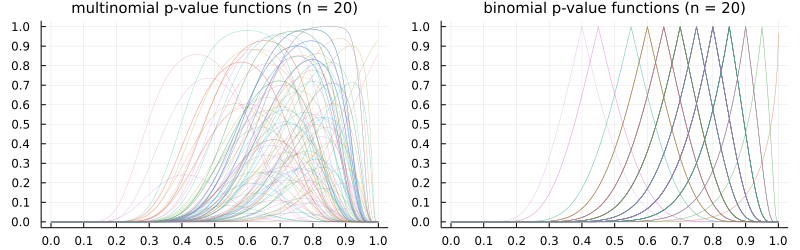

In [14]:
plot_pvaluefunctions(20, evenprob(0.75))

In [15]:
plot_pvaluefunctions(30, evenprob(0.75))

n = 30
p₀ = [0.08333333333333333, 0.25, 0.08333333333333333, 0.25, 0.08333333333333333, 0.25]
n * p₀ = [2.5, 7.5, 2.5, 7.5, 2.5, 7.5]


n = 100
p₀ = [0.08333333333333333, 0.25, 0.08333333333333333, 0.25, 0.08333333333333333, 0.25]
n * p₀ = [8.333333333333332, 25.0, 8.333333333333332, 25.0, 8.333333333333332, 25.0]


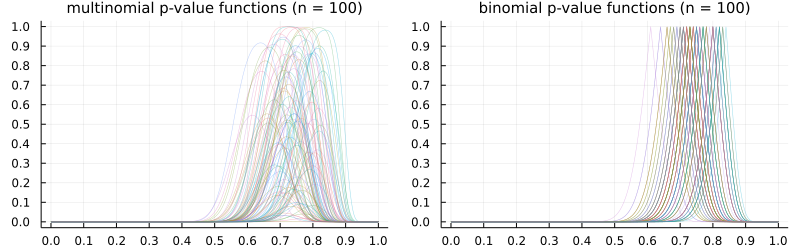

In [16]:
plot_pvaluefunctions(100, evenprob(0.75))

n = 400
p₀ = [0.08333333333333333, 0.25, 0.08333333333333333, 0.25, 0.08333333333333333, 0.25]
n * p₀ = [33.33333333333333, 100.0, 33.33333333333333, 100.0, 33.33333333333333, 100.0]


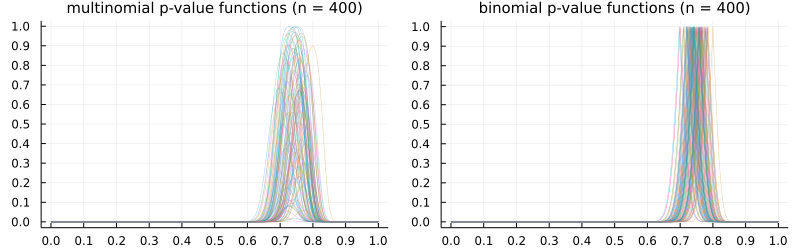

In [17]:
plot_pvaluefunctions(400, evenprob(0.75))

n = 10
p₀ = [0.03125, 0.0625, 0.09375, 0.15625, 0.25, 0.40625]
n * p₀ = [0.3125, 0.625, 0.9375, 1.5625, 2.5, 4.0625]


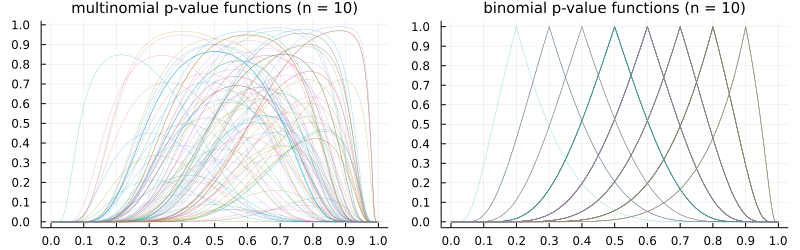

In [18]:
plot_pvaluefunctions(10, eprob([1, 2, 3, 5, 8, 13]))

n = 20
p₀ = [0.03125, 0.0625, 0.09375, 0.15625, 0.25, 0.40625]
n * p₀ = [0.625, 1.25, 1.875, 3.125, 5.0, 8.125]


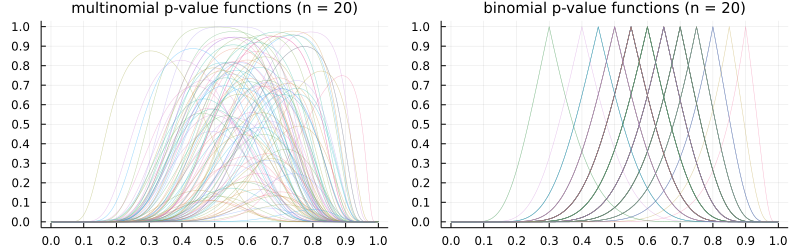

In [19]:
plot_pvaluefunctions(20, eprob([1, 2, 3, 5, 8, 13]))

n = 30
p₀ = [0.03125, 0.0625, 0.09375, 0.15625, 0.25, 0.40625]
n * p₀ = [0.9375, 1.875, 2.8125, 4.6875, 7.5, 12.1875]


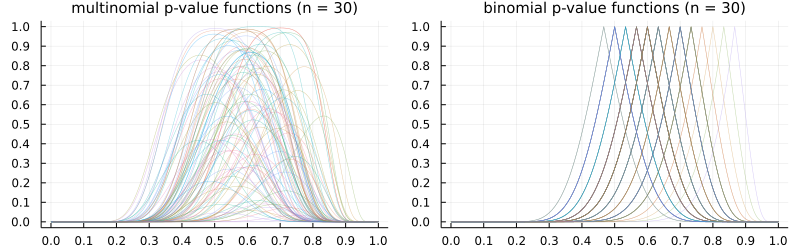

In [20]:
plot_pvaluefunctions(30, eprob([1, 2, 3, 5, 8, 13]))

n = 100
p₀ = [0.03125, 0.0625, 0.09375, 0.15625, 0.25, 0.40625]
n * p₀ = [3.125, 6.25, 9.375, 15.625, 25.0, 40.625]


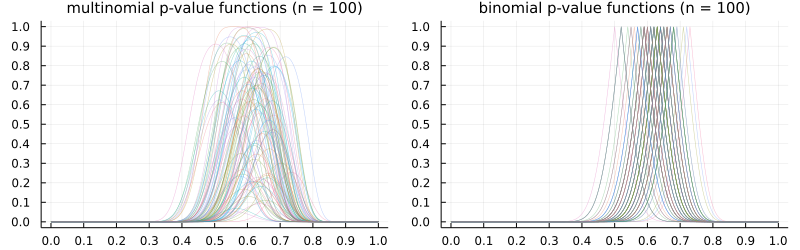

In [21]:
plot_pvaluefunctions(100, eprob([1, 2, 3, 5, 8, 13]))

n = 400
p₀ = [0.03125, 0.0625, 0.09375, 0.15625, 0.25, 0.40625]
n * p₀ = [12.5, 25.0, 37.5, 62.5, 100.0, 162.5]


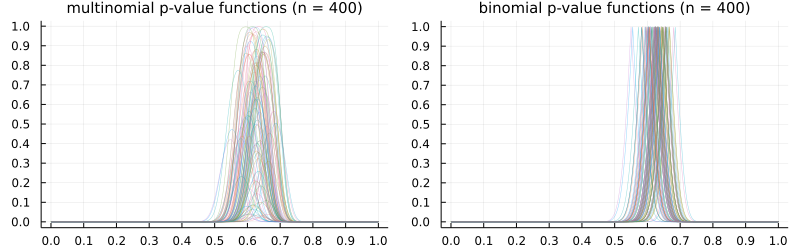

In [22]:
plot_pvaluefunctions(400, eprob([1, 2, 3, 5, 8, 13]))

n = 10
p₀ = [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
n * p₀ = [1.6666666666666665, 1.6666666666666665, 1.6666666666666665, 1.6666666666666665, 1.6666666666666665, 1.6666666666666665]


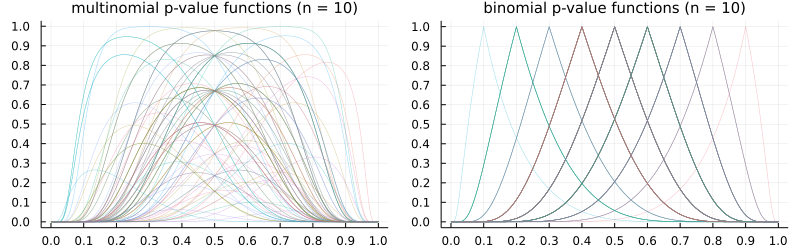

In [23]:
plot_pvaluefunctions(10, evenprob(0.5))

n = 20
p₀ = [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
n * p₀ = [3.333333333333333, 3.333333333333333, 3.333333333333333, 3.333333333333333, 3.333333333333333, 3.333333333333333]


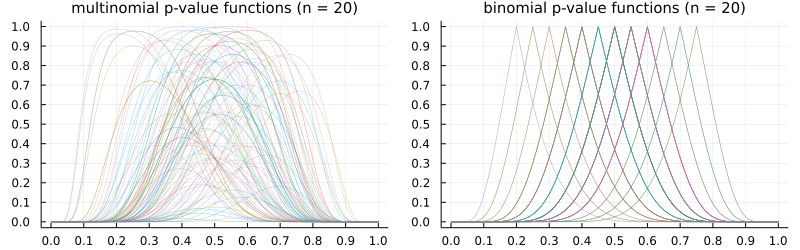

In [24]:
plot_pvaluefunctions(20, evenprob(0.5))

n = 30
p₀ = [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
n * p₀ = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0]


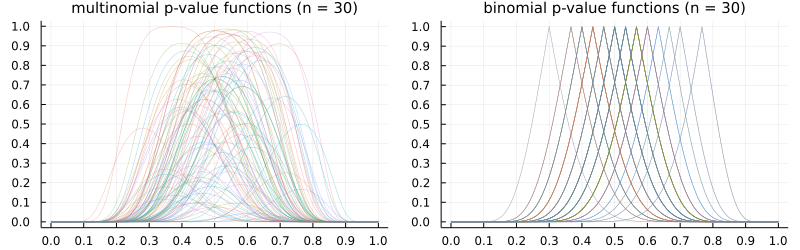

In [25]:
plot_pvaluefunctions(30, evenprob(0.5))

n = 100
p₀ = [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
n * p₀ = [16.666666666666664, 16.666666666666664, 16.666666666666664, 16.666666666666664, 16.666666666666664, 16.666666666666664]


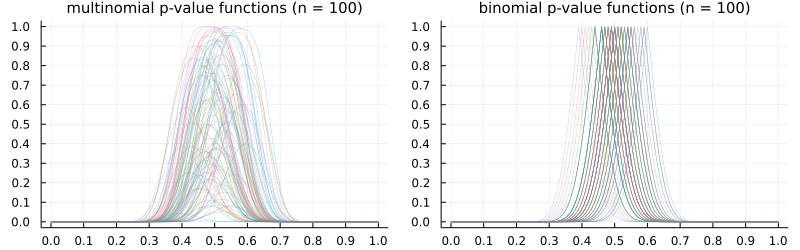

In [26]:
plot_pvaluefunctions(100, evenprob(0.5))

n = 400
p₀ = [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
n * p₀ = [66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666]


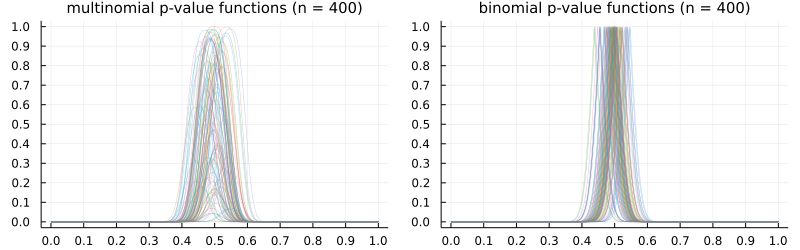

In [27]:
plot_pvaluefunctions(400, evenprob(0.5))

In [36]:
function anim_pvaluefunctions(n, p₀; L=100)
    @show n
    @show p₀
    @show n*p₀
    dist_true = Multinomial(n, p₀)
    
    anim = @animate for _ in 1:L
        plot(; xtick=0:0.1:1, ytick=0:0.1:1)
        X = rand(dist_true)
        f(t) = pval(X, n, evenprob(t, p₀))
        plot!(f, 0, 1; label="mult")
        g(t) = pval(SVector(X[1]+X[3]+X[5], X[2]+X[4]+X[6]), n, SVector(1-t, t))
        plot!(g, 0, 1; label="bin")
    end
    
    gif(anim, "anim_pvaluefunctions.gif"; fps=2)
end

anim_pvaluefunctions (generic function with 1 method)

n = 10
p₀ = [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
n * p₀ = [1.6666666666666665, 1.6666666666666665, 1.6666666666666665, 1.6666666666666665, 1.6666666666666665, 1.6666666666666665]


┌ Info: Saved animation to 
│   fn = D:\OneDrive\public\0029\anim_pvaluefunctions.gif
└ @ Plots D:\.julia\packages\Plots\dNEbX\src\animation.jl:114


Plots.AnimatedGif("D:\\OneDrive\\public\\0029\\anim_pvaluefunctions.gif")
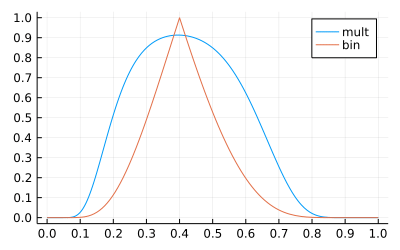

In [37]:
anim_pvaluefunctions(10, evenprob(0.5))

n = 20
p₀ = [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
n * p₀ = [3.333333333333333, 3.333333333333333, 3.333333333333333, 3.333333333333333, 3.333333333333333, 3.333333333333333]


┌ Info: Saved animation to 
│   fn = D:\OneDrive\public\0029\anim_pvaluefunctions.gif
└ @ Plots D:\.julia\packages\Plots\dNEbX\src\animation.jl:114


Plots.AnimatedGif("D:\\OneDrive\\public\\0029\\anim_pvaluefunctions.gif")
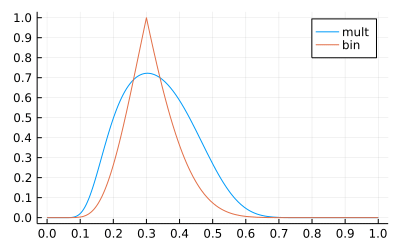

In [38]:
anim_pvaluefunctions(20, evenprob(0.5))

n = 30
p₀ = [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
n * p₀ = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0]


┌ Info: Saved animation to 
│   fn = D:\OneDrive\public\0029\anim_pvaluefunctions.gif
└ @ Plots D:\.julia\packages\Plots\dNEbX\src\animation.jl:114


Plots.AnimatedGif("D:\\OneDrive\\public\\0029\\anim_pvaluefunctions.gif")
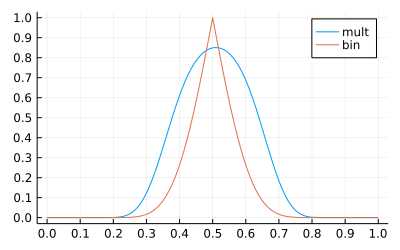

In [39]:
anim_pvaluefunctions(30, evenprob(0.5))

n = 100
p₀ = [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
n * p₀ = [16.666666666666664, 16.666666666666664, 16.666666666666664, 16.666666666666664, 16.666666666666664, 16.666666666666664]


┌ Info: Saved animation to 
│   fn = D:\OneDrive\public\0029\anim_pvaluefunctions.gif
└ @ Plots D:\.julia\packages\Plots\dNEbX\src\animation.jl:114


Plots.AnimatedGif("D:\\OneDrive\\public\\0029\\anim_pvaluefunctions.gif")
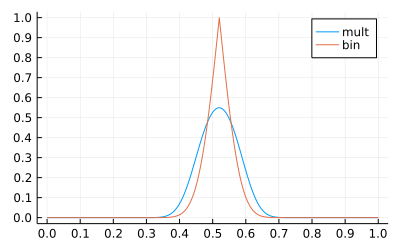

In [40]:
anim_pvaluefunctions(100, evenprob(0.5))

n = 400
p₀ = [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
n * p₀ = [66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666, 66.66666666666666]


┌ Info: Saved animation to 
│   fn = D:\OneDrive\public\0029\anim_pvaluefunctions.gif
└ @ Plots D:\.julia\packages\Plots\dNEbX\src\animation.jl:114


Plots.AnimatedGif("D:\\OneDrive\\public\\0029\\anim_pvaluefunctions.gif")
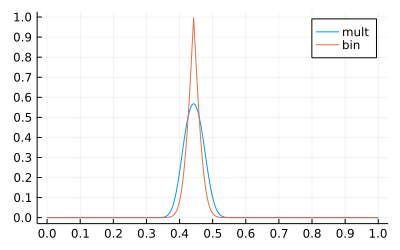

In [94]:
anim_pvaluefunctions(400, evenprob(0.5))

In [107]:
function f1()
    function g()
        x = 1
        return () -> x
    end
    x = 0
    h = g()
    return h()
end

f1()

1

In [108]:
function f2()
    function g()
        x = 1
        return () -> x
    end
    h = g()
    x = 0
    return h()
end

f2()

0

In [109]:
@code_typed f1()

CodeInfo(
1 ─ %1 = Core.Box::Type{Core.Box}
│   %2 = %new(%1)::Core.Box
│        Core.setfield!(%2, :contents, 0)::Int64
│        Core.setfield!(%2, :contents, 1)::Int64
│   %5 = Core.isdefined(%2, :contents)::Bool
└──      goto #3 if not %5
2 ─      goto #4
3 ─      $(Expr(:throw_undef_if_not, :x, false))::Any
4 ┄ %9 = Core.getfield(%2, :contents)::Any
└──      goto #5
5 ─      return %9
) => Any

In [110]:
@code_typed f2()

CodeInfo(
1 ─ %1 = Core.Box::Type{Core.Box}
│   %2 = %new(%1)::Core.Box
│        Core.setfield!(%2, :contents, 1)::Int64
│        Core.setfield!(%2, :contents, 0)::Int64
│   %5 = Core.isdefined(%2, :contents)::Bool
└──      goto #3 if not %5
2 ─      goto #4
3 ─      $(Expr(:throw_undef_if_not, :x, false))::Any
4 ┄ %9 = Core.getfield(%2, :contents)::Any
└──      goto #5
5 ─      return %9
) => Any